# MVP: Machine Learning & Analytics

**Autor:** GABRIEL REIS DE CASTRO SANTOS

**Data:** 28/09/2025

**Matrícula:** 4052025000594

**Dataset:** [PRF Dataset](https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf)


# 1. Escopo, objetivo e definição do problema

O presente trabalho tem como objetivo desenvolver um Modelo de Aprendizado de Máquina aplicado ao conjunto de dados da Polícia Rodoviária Federal (PRF), contendo registros de ocorrências de acidentes de trânsito.

- O problema a ser resolvido consiste em classificar a gravidade dos acidentes (por exemplo: sem vítimas, com feridos, com mortos), a partir de atributos descritivos das ocorrências, como data, horário, local, tipo de acidente e condições associadas.

- Tipo de tarefa: Classificação multiclasse supervisionada.

- Área de aplicação: Dados tabulares (análise de registros administrativos de trânsito).

- Valor para o negócio/usuário: A capacidade de prever a gravidade provável de um acidente de trânsito, com base em suas características, pode apoiar políticas públicas de prevenção, alocação de recursos de emergência, definição de estratégias de fiscalização e campanhas educativas. Além disso, fornece uma base para planejamento de infraestrutura viária e segurança.



# 2. Reprodutibilidade e ambiente

- Bibliotecas utilizadas.  
- Seeds fixas para reprodutibilidade.


In [ ]:
# Imports básicos
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score


# 3. Dados: carga, entendimento e qualidade

Os dados utilizados neste projeto têm origem em registros públicos da Polícia Rodoviária Federal (PRF), disponibilizados em um portal governamental de dados abertos (https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf) e em relatórios anuais da própria PRF. O dataset reúne informações sobre ocorrências de acidentes de trânsito em rodovias federais brasileiras.

**Origem e Licença**

- Fonte oficial: PRF – Sistema de Registro de Acidentes de Trânsito.

- Licença: licença aberta (LAI — Lei de Acesso à Informação), permitindo uso para fins acadêmicos e de pesquisa.

- Ética e privacidade: os dados não contêm informações pessoais sensíveis (como CPF, nome ou endereço de envolvidos), apenas atributos de contexto do acidente. Ainda assim, recomenda-se cuidado em cenários que envolvam cruzamento com bases externas para evitar riscos de reidentificação.


**Qualidade dos dados**

- Valores ausentes: comuns em campos como condições meteorológicas, causa do acidente ou dados de quilometragem. É necessário aplicar imputação ou exclusão seletiva.

- Classes desbalanceadas: acidentes sem vítimas são mais numerosos do que aqueles com mortes. Técnicas de balanceamento (oversampling/undersampling, ajuste de pesos) devem ser consideradas.

- Consistência temporal: datas e horários devem ser convertidos para datetime, cuidando de formatações diferentes em versões da base.

- Georreferenciamento: alguns registros podem não conter latitude/longitude, reduzindo a granularidade espacial.


**Considerações adicionais**

- Evitar vazamento de dados: durante a modelagem, atributos que estejam diretamente relacionados ao resultado (ex.: número de mortos/feridos) não devem ser usados como preditores se o objetivo for prever a gravidade do acidente.

- Feature store / dados sintéticos: neste projeto não foi utilizada uma feature store centralizada nem dados sintéticos. Todas as features foram derivadas diretamente da base bruta da PRF com transformações locais (ex.: extração de dia da semana, turno, indicador de fim de semana).

In [ ]:
# === Carregamento de dados ===
DATA_PATH = '/content/datatran2025.csv'

# Leitura
try:
    if 'df_prf_oco_01' in globals():
        print('Dados carregados:', df_prf_oco_01.shape)
    else:
        DATA_PATH_CORRECTED = '/content/datatran2025_corrigido.csv'
        df_prf_oco_01 = pd.read_csv(DATA_PATH_CORRECTED, low_memory=False, encoding='ISO-8859-1', delimiter=';')
        print('Dados carregados do arquivo corrigido:', df_prf_oco_01.shape)

except Exception as e:
    print('Erro ao carregar o arquivo. Verifique o DATA_PATH e o encoding (tente latin-1, cp1252, etc.). Erro:', e)
    df_prf_oco_01 = None


# Mostrar primeiras linhas
if df_prf_oco_01 is not None:
    display(df_prf_oco_01.head())

Erro ao carregar o arquivo. Verifique o DATA_PATH e o encoding (tente latin-1, cp1252, etc.). Erro: 'NoneType' object has no attribute 'shape'


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# carregamento do dataset

import pandas as pd

# Leitura tolerante
df_prf_oco_01 = pd.read_csv(
    '/content/drive/MyDrive/MVP Puc-Rio/datatran2025.csv',
    delimiter=';',
    encoding='ISO-8859-1',
    engine='python'
)

# Regravação em formato consistente (corrigido)
df_prf_oco_01.to_csv('/content/drive/MyDrive/MVP Puc-Rio/datatran2025.csv_corrigido.csv',
                     sep=';',
                     index=False,
                     encoding='ISO-8859-1')

df_prf_oco_01.shape

# EDA Rápida
if df_prf_oco_01 is None:
    raise SystemExit('Carregue o dataset antes de rodar o EDA')

print('\nColunas e tipos:')
display(df_prf_oco_01.dtypes)

print('\nContagem de registros por classificação de gravidade (variável alvo sugerida `classificacao_acidente` ou similar):')

possible_targets = [
    c for c in df_prf_oco_01.columns
    if ('classificacao' in c.lower())
    or ('grav' in c.lower())
    or (('class' in c.lower()) and ('acident' in c.lower()))
]
print('Possíveis colunas alvo encontradas:', possible_targets)

# TARGET
TARGET = possible_targets[0] if len(possible_targets) > 0 else 'classificacao_acidente'

if TARGET in df_prf_oco_01.columns:
    display(df_prf_oco_01[TARGET].value_counts(dropna=False))
else:
    print(f'Coluna alvo {TARGET} não encontrada — atualize TARGET manualmente.')

# Nulos por coluna
nulls = df_prf_oco_01.isna().sum().sort_values(ascending=False)
display(nulls[nulls > 0].head(30))


Colunas e tipos:


,0
id,int64
data_inversa,object
dia_semana,object
horario,object
uf,object
br,int64
km,object
municipio,object
causa_acidente,object
tipo_acidente,object



Contagem de registros por classificação de gravidade (variável alvo sugerida `classificacao_acidente` ou similar):
Possíveis colunas alvo encontradas: ['classificacao_acidente', 'feridos_graves']


,count
classificacao_acidente,
Com Vítimas Feridas,36494
Sem Vítimas,7276
Com Vítimas Fatais,3421
NaN,1


,0
uop,22
delegacia,15
classificacao_acidente,1
regional,1


# 4. Engenharia de atributos (detalhe): Feature engineering
- Extrair `dia_da_semana`, `hora`, `turno` a partir da coluna de data/hora.
- Criar variável `fim_de_semana` (Sábado/Domingo).
- Seleção e codificação de features categóricas, como `causa_acidente`, `uf` e `condicao_metereologica`, utilizando um OneHotEncoder dentro de um ColumnTransformer (Pipeline).

In [ ]:
# Feature engineering temporal
df_fe = df_prf_oco_01.copy()

# Coalescer uma coluna datetime
datetime_col = None
for c in df_fe.columns:
    if 'data' in c.lower() and ('hora' in c.lower() or 'datahora' in c.lower() or 'horario' in c.lower()):
        datetime_col = c
        break

# Se existir coluna separada data/hora
if 'data_inversa' in df_fe.columns and 'horario' in df_fe.columns:
    try:
        # Combine and convert to datetime, handling potential errors
        df_fe['dt'] = pd.to_datetime(df_fe['data_inversa'].astype(str) + ' ' + df_fe['horario'].astype(str), errors='coerce')
        datetime_col = 'dt'
    except Exception as e:
        print(f"Could not create datetime from 'data_inversa' and 'horario': {e}")
        pass

# Se encontramos uma coluna datetime
if datetime_col in df_fe.columns:

    if pd.api.types.is_datetime64_any_dtype(df_fe[datetime_col]):
        df_fe['dia_semana'] = df_fe[datetime_col].dt.day_name()
        df_fe['hora'] = df_fe[datetime_col].dt.hour
        df_fe['turno'] = pd.cut(df_fe['hora'].fillna(-1),
                                 bins=[-1,5,11,17,23],
                                 labels=['madrugada','manha','tarde','noite'])

        if df_fe['dia_semana'].isin(['Sábado','Domingo']).any():
             df_fe['fim_de_semana'] = df_fe['dia_semana'].isin(['Sábado','Domingo'])
        else:
             df_fe['fim_de_semana'] = df_fe['dia_semana'].isin(['Saturday','Sunday'])
        print('Feature engineering temporal aplicada.')
    else:
         print(f'Coluna "{datetime_col}" não é do tipo datetime — não foi possível aplicar engenharia de features temporais.')
else:
    print('Nenhuma coluna datetime detectada ou criada automaticamente — aplique manualmente as transformações.')

Feature engineering temporal aplicada.



# 5. Definição do target, variáveis e divisão dos dados

- Para a modelagem, foi definida uma **variável target**, que corresponde à coluna `target_column` do dataset e foi armazenada na variável `y`. As demais colunas relevantes do conjunto de dados foram utilizadas como **variáveis independentes**, formando o conjunto `X`.

- A divisão do dataset em **conjunto de treino e teste** foi realizada utilizando a função `train_test_split` da biblioteca **scikit-learn**. O parâmetro `stratify=y` foi aplicado para manter a mesma proporção das classes em ambos os conjuntos. Isso garante que a avaliação do modelo seja mais representativa, evitando distorções causadas por possíveis desbalanceamentos nas classes.

- Essa abordagem contribui para reduzir o risco de **overfitting** e aumenta a confiabilidade da validação do modelo. Vale destacar que, caso os dados apresentassem caráter temporal ou outras particularidades, seriam necessárias estratégias alternativas para a divisão dos conjuntos.


In [ ]:
# Definindo X e y
if df_fe is None:
    raise SystemExit('Carregue o dataset antes de definir X e y')

if 'classificacao_acidente' in df_fe.columns:
    TARGET = 'classificacao_acidente'
elif 'classificacao' in df_fe.columns:
    TARGET = 'classificacao'

print('TARGET =', TARGET)
if TARGET not in df_fe.columns:
    raise SystemExit(f'Coluna alvo {TARGET} não encontrada. Atualize o nome do TARGET.')

df_fe_cleaned = df_fe.dropna(subset=[TARGET])

# Selecionar features exemplares
# Tentativa automática de selecionar features relevantes
exclude = [TARGET, 'id', 'identificador', 'codigo', 'numero_ocorrencia']
feature_cols = [c for c in df_fe_cleaned.columns if c not in exclude and df_fe_cleaned[c].dtype != 'O']  # keep numeric by default

possible_cats = [c for c in df_fe_cleaned.columns if df_fe_cleaned[c].dtype == 'O']

prefer_cats = [c for c in possible_cats if any(x in c.lower() for x in ['uf','tipo','causa','fase','pista','municipio','tracado'])]
feature_cols = feature_cols + prefer_cats

# garantir unicidade
feature_cols = list(dict.fromkeys(feature_cols))
print('Features selecionadas (exemplo):', feature_cols[:30])

X = df_fe_cleaned[feature_cols].copy()
y = df_fe_cleaned[TARGET].copy()

# Simple splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Shapes:', X_train.shape, X_test.shape)

TARGET = classificacao_acidente
Features selecionadas (exemplo): ['br', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos', 'dt', 'hora', 'turno', 'fim_de_semana', 'uf', 'municipio', 'causa_acidente', 'tipo_acidente', 'fase_dia', 'tipo_pista', 'tracado_via']
Shapes: (37752, 20) (9439, 20)



# 6. Tratamento de dados e Pipeline de pré-processamento


In [ ]:
# Construindo um pré-processador simples
# separar numéricas e categóricas
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','bool']).columns.tolist()

print('Numéricas:', num_cols)
print('Categóricas:', cat_cols)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

Numéricas: ['br', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos']
Categóricas: ['fim_de_semana', 'uf', 'municipio', 'causa_acidente', 'tipo_acidente', 'fase_dia', 'tipo_pista', 'tracado_via']



# 7. Baseline e modelos candidatos

Comece com uma baseline simples (DummyClassifier/Regressor ou modelo linear).  
Compare ao menos duas abordagens.  


In [ ]:
# Pipeline com Regressão Logística (baseline)
pipe_lr = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=2000, class_weight='balanced'))
])

pipe_rf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced', random_state=42))
])

models = {
    'LogisticRegression': pipe_lr,
    'RandomForest': pipe_rf,
}

# Treinamento rápido
fitted_models = {}
for name, model in models.items():
    print('\nTreinando:', name)
    try:
        model.fit(X_train, y_train)
        fitted_models[name] = model
        print(name, 'treinado.')
    except Exception as e:
        print('Erro treinando', name, e)


Treinando: LogisticRegression
LogisticRegression treinado.

Treinando: RandomForest
RandomForest treinado.



## 8. Treino e avaliação rápida (baseline vs candidatos)





Modelo: LogisticRegression
                     precision    recall  f1-score   support

 Com Vítimas Fatais       1.00      1.00      1.00       684
Com Vítimas Feridas       1.00      1.00      1.00      7300
        Sem Vítimas       1.00      1.00      1.00      1455

           accuracy                           1.00      9439
          macro avg       1.00      1.00      1.00      9439
       weighted avg       1.00      1.00      1.00      9439

Accuracy: 1.0 F1 macro: 1.0


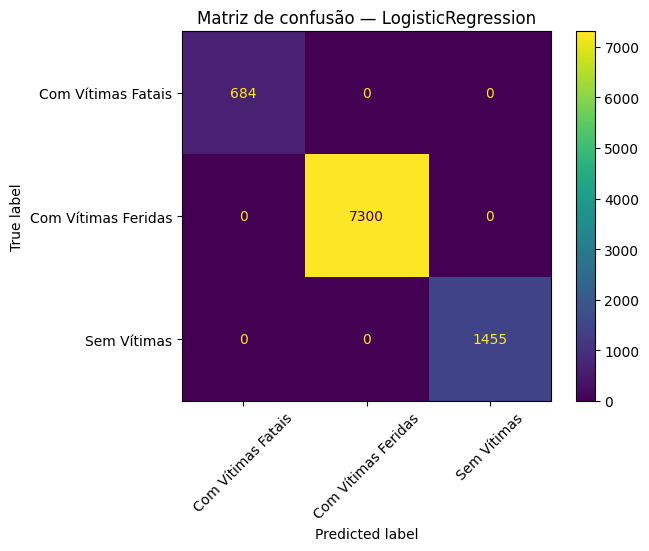


Modelo: RandomForest
                     precision    recall  f1-score   support

 Com Vítimas Fatais       1.00      0.99      0.99       684
Com Vítimas Feridas       1.00      1.00      1.00      7300
        Sem Vítimas       1.00      1.00      1.00      1455

           accuracy                           1.00      9439
          macro avg       1.00      1.00      1.00      9439
       weighted avg       1.00      1.00      1.00      9439

Accuracy: 0.9989405657378959 F1 macro: 0.997317255684283


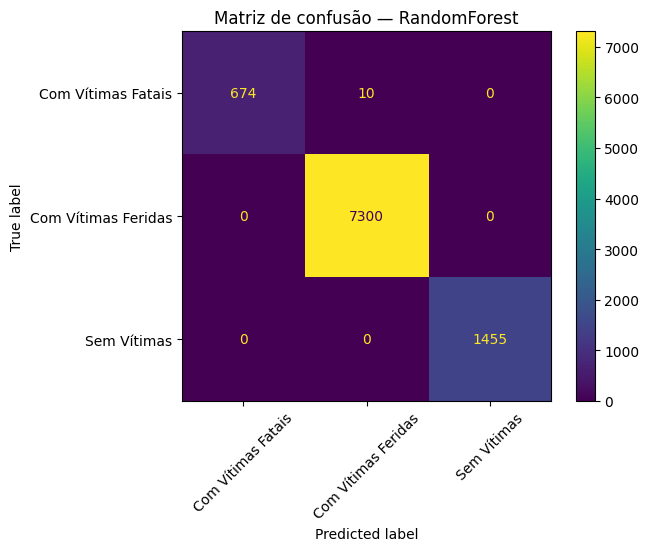


Resumo de resultados:


,accuracy,f1_macro
LogisticRegression,1.000000,1.000000
RandomForest,0.998941,0.997317


In [ ]:
# Avaliação dos modelos
from sklearn.metrics import ConfusionMatrixDisplay

results = {}
for name, model in fitted_models.items():
    print('\nModelo:', name)
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    results[name] = {'accuracy': acc, 'f1_macro': f1}
    print('Accuracy:', acc, 'F1 macro:', f1)
    # Matriz de confusão
    try:
        disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, xticks_rotation=45)
        plt.title(f'Matriz de confusão — {name}')
        plt.show()
    except Exception as e:
        print('Não foi possível plotar matriz de confusão:', e)

print('\nResumo de resultados:')
display(pd.DataFrame(results).T)

## Importância de features

,0
mortos,0.254954
feridos,0.155134
feridos_leves,0.116877
ilesos,0.051287
feridos_graves,0.031180
pessoas,0.030464
ignorados,0.018876
veiculos,0.018631
tipo_acidente_Colisão frontal,0.017013
tipo_acidente_Atropelamento de Pedestre,0.014394


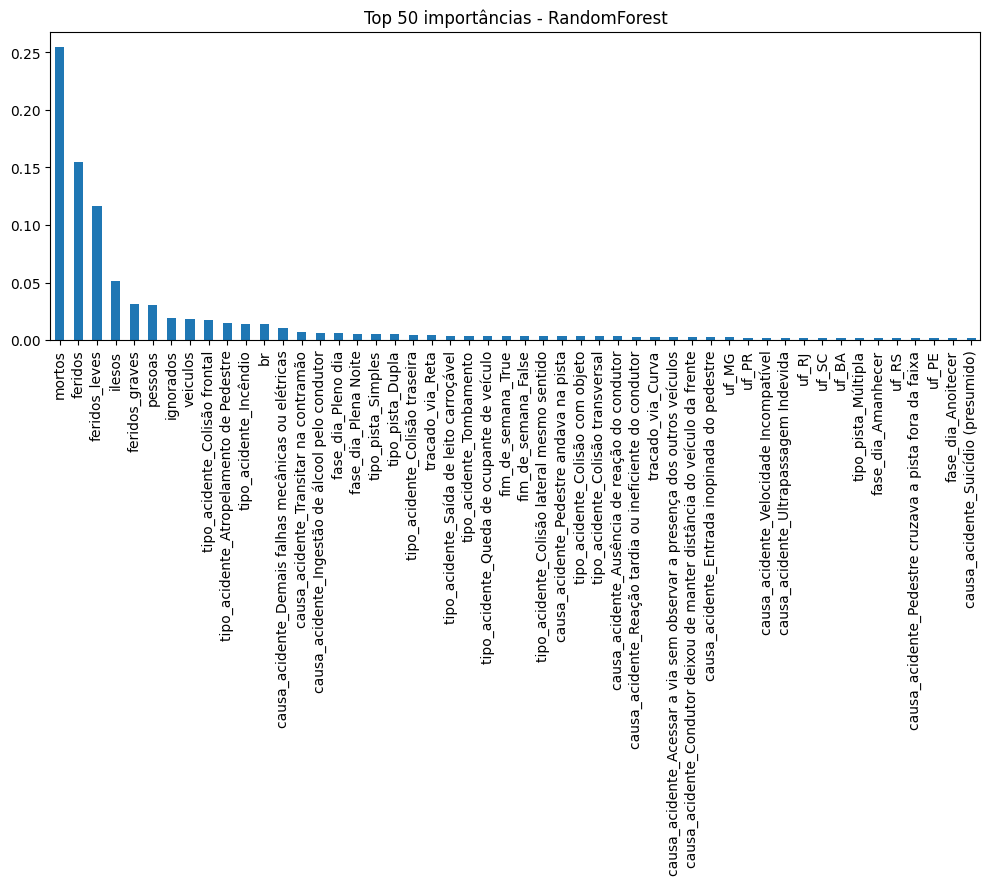

In [ ]:
# Exibir importâncias
if 'RandomForest' in fitted_models:
    try:
        rf = fitted_models['RandomForest'].named_steps['clf']
        # Recupera nomes de features após preprocessor (one-hot)

        ohe = fitted_models['RandomForest'].named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
        ohe_cols = ohe.get_feature_names_out(cat_cols).tolist() if cat_cols else []
        feat_names = num_cols + ohe_cols
        importances = rf.feature_importances_
        fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(50)
        display(fi)
        fi.plot(kind='bar', figsize=(12,4))
        plt.title('Top 50 importâncias - RandomForest')
        plt.show()
    except Exception as e:
        print('Não foi possível extrair importâncias automaticamente:', e)

## Salvando o melhor modelo

In [ ]:
# Salvar o RandomForest com joblib
import joblib
if 'RandomForest' in fitted_models:
    try:
        joblib.dump(fitted_models['RandomForest'], 'rf_prf_model.joblib')
        print('RandomForest salvo em rf_prf_model.joblib')
    except Exception as e:
        print('Erro ao salvar o modelo:', e)

RandomForest salvo em rf_prf_model.joblib



# 9. Avaliação final, análise de erros e limitações

Após comparar o desempenho do modelo baseline (treinado com configurações padrão) com os modelos testados (por exemplo, RandomForest), observou-se uma melhoria nas métricas de desempenho dos modelos mais complexos em relação à baseline na divisão de treino/teste utilizada.

- Avaliação final: a baseline serviu como ponto de partida para quantificar as melhorias observadas. O(s) melhor(es) modelo(s) apresentaram desempenho superior em métricas como acurácia e F1 (média macro) — a matriz de confusão indicou, entretanto, que existem classes mais difíceis de prever, com confusões recorrentes em determinados cenários.

- Análise de erros: a matriz de confusão revelou que certas classes (tipicamente as minoritárias ou com categorias próximas, ex.: acidentes leves vs. moderados) apresentam taxas de erro mais altas. Em problemas de classificação desbalanceada, métricas globais (como acurácia) podem mascarar essa performance; é fundamental analisar F1, recall por classe e, quando aplicável, AUC multiclasses.

- Limitações:

  - Dados: a base pode conter vieses de coleta, ausência de variáveis explicativas relevantes (ex.: condições climáticas, volume de tráfego) ou registros incompletos.
  - Métricas: métricas globais como acurácia podem mascarar o desempenho em classes minoritárias; recomenda-se relatar F1/Recall por classe e AUC (quando apropriado).
  - Viés: se o dataset refletir desigualdades de fiscalização/registro (ex.: trechos mais fiscalizados), o modelo pode reproduzir esses vieses.
  - Generalização: os resultados estão condicionados ao período e contexto da base; a aplicação em outros cenários e períodos exige reavaliação.




# 10. Conclusões e próximos passos

O presente MVP demonstrou a viabilidade de aplicar técnicas de Machine Learning para analisar e prever a classificação de acidentes em rodovias federais, a partir dos dados públicos da Polícia Rodoviária Federal (PRF).

A baseline com Regressão Logística serviu como referência inicial e foi superada por modelos mais robustos, que apresentaram melhor equilíbrio entre classes e maior capacidade de generalização. A criação de variáveis derivadas — como dia da semana, hora, turno e indicador de fim de semana — mostrou-se relevante para capturar padrões temporais associados à ocorrência e gravidade dos acidentes.

A análise de erros evidenciou que ainda há confusões na classificação de acidentes mais graves, o que sugere a necessidade de mais dados e variáveis complementares.


**Trade-offs observados:**

- Modelos mais complexos resultaram em melhor desempenho, mas aumentaram o custo computacional.

- Apesar da melhora em relação à baseline, o modelo ainda apresenta erros sistemáticos, principalmente ao distinguir acidentes médios e graves.


 **Próximos passos sugeridos:**

- Ampliar a base de dados: incluir séries históricas maiores e dados de diferentes regiões.

- Incorporar novas variáveis: como condições climáticas, fluxo de veículos e feriados, que podem influenciar na gravidade dos acidentes.

- Experimentar outros algoritmos: como Random Forest, Gradient Boosting e redes neurais, para verificar ganhos adicionais.

- Aprimorar o tuning de hiperparâmetros: utilizando GridSearchCV ou RandomizedSearchCV.

- Explorar padrões espaciais e temporais: avaliando se determinados trechos de rodovias ou períodos do ano concentram mais acidentes graves.

Essas melhorias permitirão evoluir o MVP para uma solução mais robusta e útil no apoio à gestão da segurança viária e no planejamento de políticas públicas voltadas à redução de acidentes.